# Cornerplots of various features for lensed system
### SDSS vs OM10 (realized by Galsim)

The OM10 mock lensed quasar catalog qso_mock.fits contains a list of LSST-like samples. Using the OM10 mock catalog and observation history data, we can generate a toy catalog for SLRealizer. Using the toy catalog, we can null-deblend the catalog and generate the cornerplot to easily compare different features. We use Galsim to null-deblend and realize the catalog. Then, we compared the OM10 features with SDSS features.

In [7]:
from __future__ import print_function
from astropy.table import Table, hstack
import astropy.io.fits as pyfits
import sys, os
import desc.slrealizer
import warnings
import numpy as np
warnings.filterwarnings("ignore")

The lines below enable the jupyter notebook to display inline plots.

In [8]:
import matplotlib
warnings.filterwarnings("ignore")
%matplotlib inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

Here, we initialize SLRealizer constructor

In [9]:
realizer = desc.slrealizer.SLRealizer()

##  Make the feature set

Based on the cornerplot that we drew of SDSS and OM10, we make a new catalog that has only useful features. We choose six features:

- Difference in sizes between u and z bands
- Difference in ellipticities between u and z bands (e)
- Difference in rotation angles of the systems between u and z bands (ϕ)
- Difference in angles between centroid positions and galactic shears (ω) 
- Difference in magnitudes between u and z bands
- Difference in positions of the centroid between u and z bands (x)

In order to do so, we first load the dependencies:

In [10]:
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import desc.slrealizer

Then, we read in the object_table and the sdss_table.

In [13]:
object_table = pd.read_csv('../data/object_catalog_galsim_noise_perfect.csv')
sdss_table = pd.read_csv('../data/sdss_object.csv')

Then, we calculate each entrees of six useful features. First, we do that for object_table(om10) and save into `truth_data.csv`.

In [28]:
features = np.array([])
u_e = object_table['u_e']
z_e = object_table['z_e']
u_phi = object_table['u_phi']
z_phi = object_table['z_phi']
delta_e = u_e - z_e
delta_phi = (object_table['u_phi']-object_table['z_phi'])
u = desc.slrealizer.return_zeropoint()-2.5*np.log10(object_table['u_flux'])
z = desc.slrealizer.return_zeropoint()-2.5*np.log10(object_table['z_flux'])
u_z = u - z
u_x = object_table['u_x'] - object_table['r_x']
u_y = object_table['u_y'] - object_table['r_y']
u_e1 = object_table['u_e1']
u_e2 = object_table['u_e2']
u_ex = u_x* (u_e1*np.cos(u_phi) - u_e2*np.sin(u_phi))
u_ey = u_y* (u_e1*np.sin(u_phi) + u_e2*np.cos(u_phi))
z_x = object_table['z_x'] - object_table['r_x']
z_y = object_table['z_y'] - object_table['r_y']
z_e1 = object_table['z_e1']
z_e2 = object_table['z_e2']
z_ex = z_x * (z_e1*np.cos(z_phi) - z_e2*np.sin(z_phi))
z_ey = z_y * (z_e1*np.cos(z_phi) - z_e2*np.sin(z_phi))
pos_mod_u = np.sqrt(u_x*u_x + u_y*u_y)
pos_mod_z = np.sqrt(z_x*z_x + z_y*z_y)
delta_x = np.sqrt((u_x - z_x) * (u_x - z_x) + (u_y - z_y) * (u_y - z_y))
delta_size = object_table['u_size']-object_table['z_size']

u_omega = (u_ex+u_ey)/(u_e*pos_mod_u)
z_omega = (z_ex+z_ey)/(z_e*pos_mod_z)

diff_x = u_x - z_x
diff_y = u_y - z_y
pos_mod_diff = np.sqrt(diff_x * diff_x + diff_y * diff_y)

omega_u_num = u_x*u_e*np.cos(2*u_phi) + u_x*u_e*np.sqrt(2)/2*np.sin(2*u_phi) + np.sqrt(2)/2 * u_y * u_e * np.sin(2*u_phi)
omega_u_den = pos_mod_u * u_e *10
omag_u = omega_u_num / omega_u_den

omega_z_num = z_x*z_e*np.cos(2*z_phi) + z_x*z_e*np.sqrt(2)/2*np.sin(2*z_phi) + np.sqrt(2)/2 *z_y * z_e * np.sin(2*z_phi)
omega_z_den = pos_mod_z * z_e * 10
omag_z = omega_z_num / omega_z_den

delta_omega = omag_u-omag_z

delta_phi = delta_phi*57.2958

truth = [1] * len(delta_omega)

features = np.append(features, truth)
features = np.append(features, delta_e)
features = np.append(features, delta_phi)
features = np.append(features, u_z)
features = np.append(features, delta_x)
features = np.append(features, delta_size)
features = np.append(features, delta_omega)
features = features.reshape(7, len(u_x)).transpose()
data = pd.DataFrame(features, columns=['truth', 'delta_e', 'delta_phi', 'u_z', 'delta_x', 'delta_size', 'delta_omega'])
data.to_csv('../data/truth_data.csv')
print(data)

      truth   delta_e  delta_phi       u_z   delta_x  delta_size  delta_omega
0       1.0 -0.025915  -1.107102 -0.681569  0.021173    0.160582     0.255302
1       1.0  0.021835   0.402320 -0.425839  0.004656   -0.091169    -0.017974
2       1.0  0.028419  -1.151119 -0.685951  0.000564    0.010715    -0.093143
3       1.0  0.025229   0.006974 -0.493946  0.004960   -0.122463     0.010931
4       1.0  0.022732   0.877403 -1.684077  0.123083    0.650938    -0.016721
5       1.0 -0.011331   0.631168 -3.027182  1.012805    3.046674     0.257477
6       1.0 -0.408916  42.646809 -3.358599  0.450436    3.971045    -0.014255
7       1.0  0.066158   0.073507 -0.665486  0.000968    0.016784     0.005122
8       1.0  0.027425  -0.000346 -0.401236  0.004111   -0.135346    -0.260779
9       1.0  0.165400  17.737848 -3.566221  0.131018    4.694982     0.187466
10      1.0 -0.171364  -5.669029 -3.888808  0.437288    9.102211     0.147529
11      1.0  0.023907   0.781761 -0.656193  0.002466    0.072344

Do the same for sdss_table, saving into `false_data`.

In [18]:
features = np.array([])
u_e = sdss_table['u_e']
z_e = sdss_table['z_e']
u_phi = sdss_table['u_phi']
z_phi = sdss_table['z_phi']
delta_e = u_e - z_e
delta_phi = (sdss_table['u_phi']-sdss_table['z_phi'])
u = desc.slrealizer.return_zeropoint()-2.5*np.log10(sdss_table['u_flux'])
z = desc.slrealizer.return_zeropoint()-2.5*np.log10(sdss_table['z_flux'])
u_z = u - z
u_x = sdss_table['u_x'] - sdss_table['r_x']
u_y = sdss_table['u_y'] - sdss_table['r_y']
u_e1 = sdss_table['u_e1']
u_e2 = sdss_table['u_e2']
u_ex = u_x* (u_e1*np.cos(u_phi) - u_e2*np.sin(u_phi))
u_ey = u_y* (u_e1*np.sin(u_phi) + u_e2*np.cos(u_phi))
z_x = sdss_table['z_x'] - sdss_table['r_x']
z_y = sdss_table['z_y'] - sdss_table['r_y']
z_e1 = sdss_table['z_e1']
z_e2 = sdss_table['z_e2']
z_ex = z_x * (z_e1*np.cos(z_phi) - z_e2*np.sin(z_phi))
z_ey = z_y * (z_e1*np.cos(z_phi) - z_e2*np.sin(z_phi))
pos_mod_u = np.sqrt(u_x*u_x + u_y*u_y)
pos_mod_z = np.sqrt(z_x*z_x + z_y*z_y)
delta_x = np.sqrt((u_x - z_x) * (u_x - z_x) + (u_y - z_y) * (u_y - z_y))
delta_size = sdss_table['u_size']-sdss_table['z_size']

u_omega = (u_ex+u_ey)/(u_e*pos_mod_u)
z_omega = (z_ex+z_ey)/(z_e*pos_mod_z)

diff_x = u_x - z_x
diff_y = u_y - z_y
pos_mod_diff = np.sqrt(diff_x * diff_x + diff_y * diff_y)

omega_u_num = u_x*u_e*np.cos(2*u_phi) + u_x*u_e*np.sqrt(2)/2*np.sin(2*u_phi) + np.sqrt(2)/2 * u_y * u_e * np.sin(2*u_phi)
omega_u_den = pos_mod_u * u_e *10
omag_u = omega_u_num / omega_u_den

omega_z_num = z_x*z_e*np.cos(2*z_phi) + z_x*z_e*np.sqrt(2)/2*np.sin(2*z_phi) + np.sqrt(2)/2 *z_y * z_e * np.sin(2*z_phi)
omega_z_den = pos_mod_z * z_e * 10
omag_z = omega_z_num / omega_z_den

delta_omega = omag_u-omag_z

delta_phi = delta_phi*57.2958

truth = [0] * len(delta_omega)

features = np.append(features, truth)
features = np.append(features, delta_e)
features = np.append(features, delta_phi)
features = np.append(features, u_z)
features = np.append(features, delta_x)
features = np.append(features, delta_size)
features = np.append(features, delta_omega)
features = features.reshape(7, len(u_x)).transpose()
sdss_data = pd.DataFrame(features, columns=['truth', 'delta_e', 'delta_phi', 'u_z', 'delta_x', 'delta_size', 'delta_omega'])
sdss_data.to_csv('../data/false_data.csv')

Then, we merged the truth(om10) and the false(sdss) to one catalog, saving it into `training_data.csv`.

In [19]:
df_col_merged =pd.concat([data, sdss_data], axis=0)
df_col_merged = df_col_merged.sample(frac=1)
df_col_merged.to_csv('../data/training_data.csv')

# Machine Learning + Precision Recall Curve for various methods

We are going two use three different algorithms : linearSVC, K-neighbors, and Random Forest. For the K-neighbors and Random Forest, we are going to change the number of neighbors and leaves. Then, we will see which classifier has the best performance.

In order to do so, we import the necessary packages:

In [20]:
from sklearn import svm
import sklearn
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

Then, we divide training set and the test set within the whole data set. 

In [21]:
df_col_merged = df_col_merged.as_matrix()
y = df_col_merged[:,0]
last_col_index = len(df_col_merged[0])
X = df_col_merged[:,1: last_col_index]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

Then, while training the Machine Learning algorithms, we also produce the precision-recall curve for each method so that we can compare the performances.

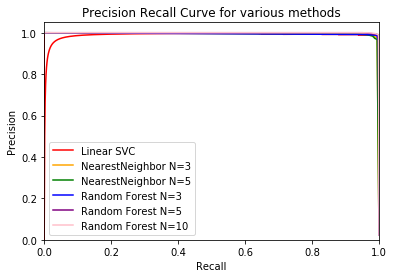

In [22]:
# linearsvc
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
y_score = clf.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision, label='Linear SVC', color='red')

# kneighbors n=3
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train) 
y_score = neigh.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision, label='NearestNeighbor N=3', color='orange')

# kneighbors n=5
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train) 
y_score = neigh.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision, label='NearestNeighbor N=5', color='green')

# Random Forest N = 3
clf = RandomForestClassifier(n_estimators=3)
clf = clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision, label='Random Forest N=3', color='blue')

# Random Forest N = 5
clf = RandomForestClassifier(n_estimators=5)
clf = clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision, label='Random Forest N=5', color='purple')

# Random Forest N = 10
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision, label='Random Forest N=10', color='pink')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.title('Precision Recall Curve for various methods')

# ROC Curve for various methods

We are going two use three different algorithms : linearSVC, K-neighbors, and Random Forest. For the K-neighbors and Random Forest, we are going to change the number of neighbors and leaves. Then, we will see which classifier has the best performance.

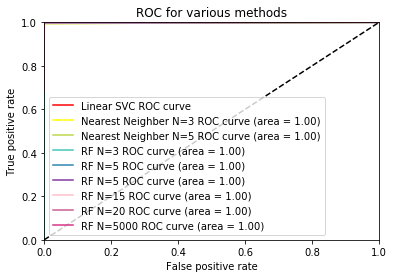

In [23]:
# linearsvc
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
y_score = clf.decision_function(X_test)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_score)
plt.plot(fpr, tpr, color='red', label='Linear SVC ROC curve')

# kneighbors n=3
neigh = KNeighborsClassifier(n_neighbors=3)
neigh = neigh.fit(X_train, y_train) 
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, neigh.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='yellow', label='Nearest Neighber N=3 ROC curve (area = %0.2f)' % roc_auc)

# kneighbors n=5
neigh = KNeighborsClassifier(n_neighbors=5)
neigh = neigh.fit(X_train, y_train) 
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, neigh.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#bad64d', label='Nearest Neighber N=5 ROC curve (area = %0.2f)' % roc_auc)

# Random Forest N = 3
clf = RandomForestClassifier(n_estimators=3, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#43c6b7', label='RF N=3 ROC curve (area = %0.2f)' % roc_auc)


# Random Forest N = 3
clf = RandomForestClassifier(n_estimators=5, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#2b84ad', label='RF N=5 ROC curve (area = %0.2f)' % roc_auc)

# Random Forest N = 5
clf = RandomForestClassifier(n_estimators=10, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#8138a0', label='RF N=5 ROC curve (area = %0.2f)' % roc_auc)

# Random Forest N = 10
clf = RandomForestClassifier(n_estimators=15, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='pink', label='RF N=15 ROC curve (area = %0.2f)' % roc_auc)


clf = RandomForestClassifier(n_estimators=20, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#cc5d94', label='RF N=20 ROC curve (area = %0.2f)' % roc_auc)

clf = RandomForestClassifier(n_estimators=5000, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#d63384', label='RF N=5000 ROC curve (area = %0.2f)' % roc_auc)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.title('ROC for various methods')

It is a little hard to see where the turn-off points are, so let's concentrate on the top left corner.

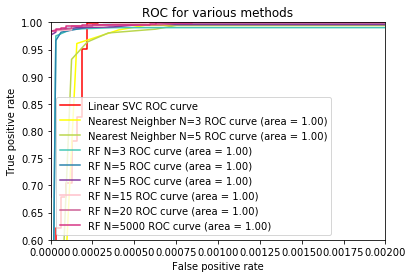

In [26]:
# linearsvc
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
y_score = clf.decision_function(X_test)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_score)
plt.plot(fpr, tpr, color='red', label='Linear SVC ROC curve')

# kneighbors n=3
neigh = KNeighborsClassifier(n_neighbors=3)
neigh = neigh.fit(X_train, y_train) 
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, neigh.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='yellow', label='Nearest Neighber N=3 ROC curve (area = %0.2f)' % roc_auc)

# kneighbors n=5
neigh = KNeighborsClassifier(n_neighbors=5)
neigh = neigh.fit(X_train, y_train) 
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, neigh.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#bad64d', label='Nearest Neighber N=5 ROC curve (area = %0.2f)' % roc_auc)

# Random Forest N = 3
clf = RandomForestClassifier(n_estimators=3, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#43c6b7', label='RF N=3 ROC curve (area = %0.2f)' % roc_auc)


# Random Forest N = 3
clf = RandomForestClassifier(n_estimators=5, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#2b84ad', label='RF N=5 ROC curve (area = %0.2f)' % roc_auc)

# Random Forest N = 5
clf = RandomForestClassifier(n_estimators=10, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#8138a0', label='RF N=5 ROC curve (area = %0.2f)' % roc_auc)

# Random Forest N = 10
clf = RandomForestClassifier(n_estimators=15, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='pink', label='RF N=15 ROC curve (area = %0.2f)' % roc_auc)


clf = RandomForestClassifier(n_estimators=20, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#cc5d94', label='RF N=20 ROC curve (area = %0.2f)' % roc_auc)

clf = RandomForestClassifier(n_estimators=5000, max_features=None)
clf = clf.fit(X_train, y_train)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='#d63384', label='RF N=5000 ROC curve (area = %0.2f)' % roc_auc)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim([0.6, 1.00])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.002])
plt.legend(loc="lower left")
plt.title('ROC for various methods')

# Feature Selection

We could see that the random forest classifier with N=10 and above performed the best. Because Random Forest can also give the measures of how the useful each feature was, we can draw the simple histogram that shows feature importance.

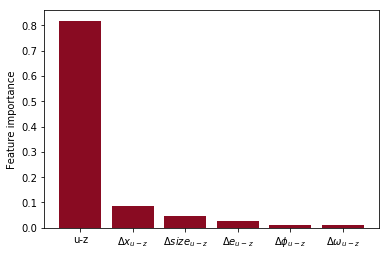

In [25]:
# Random Forest N = 10
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)

col = pd.DataFrame(df_col_merged[:,1: last_col_index], columns=['$\Delta e_{u-z}$', '$\Delta \phi_{u-z}$', 'u-z', '$\Delta x_{u-z}$', '$\Delta size_{u-z}$', '$\Delta \omega_{u-z}$'])
importance = sorted(zip(col.columns.values,clf.feature_importances_),key=lambda q: q[1],reverse=True)
row = zip(*importance)[0]
column = zip(*importance)[1]
x_pos = np.arange(len(row))
plt.bar(x_pos, column, align='center', color='#890b22')
plt.xticks(x_pos, row)
plt.ylabel('Feature importance')

# Determine the false positive and true positive rates
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = sklearn.metrics.auc(fpr, tpr)